In [56]:
! pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 5.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 MB 3.3 MB/s eta 0:00:0000:0100:01


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import glob
from collections import defaultdict
import datetime
import pytz
from astral import LocationInfo
from astral.sun import sun
import seaborn as sns
import sklearn.preprocessing import OneH
warnings.filterwarnings('ignore')

In [4]:
path =  "./data"
relPathApart =  f"{path}/apartment"
relPathWeather = f"{path}/apartment-weather"
year = 2016
aptNum = 114
startDate = '2016-02-01'
endDate = '2016-03-03'

In [5]:
! mkdir -p "./data"
! wget -nc "https://lass.cs.umass.edu/smarttraces/2017/apartment-electrical.tar.gz" -P "./data"
! wget -nc "https://lass.cs.umass.edu/smarttraces/2017/apartment-weather.tar.gz" -P "./data"

File ‘./data/apartment-electrical.tar.gz’ already there; not retrieving.

File ‘./data/apartment-weather.tar.gz’ already there; not retrieving.



In [6]:
! tar -xf "./data/apartment-electrical.tar.gz" -C "./data"
! tar -xf "./data/apartment-weather.tar.gz" -C "./data"

In [7]:
apartDfs = []
allFiles = glob.glob(f"{relPathApart}/{year}/*.csv")
for fileName in allFiles:
  df = pd.read_csv(fileName, parse_dates=[1], header=None, names=['date', 'power'])
  df["power"] = df["power"].astype(float)
  apartDfs.append(df)

print(apartDfs)

[                       date     power
0       2016-01-01 00:00:00  0.588867
1       2016-01-01 00:01:00  0.418467
2       2016-01-01 00:02:00  0.203583
3       2016-01-01 00:03:00  0.203600
4       2016-01-01 00:04:00  0.203600
...                     ...       ...
503770  2016-12-15 20:10:00  0.005217
503771  2016-12-15 20:11:00  0.005467
503772  2016-12-15 20:12:00  0.004733
503773  2016-12-15 20:13:00  0.004733
503774  2016-12-15 20:14:00  0.004667

[503775 rows x 2 columns],                        date     power
0       2016-01-01 00:00:00  0.386450
1       2016-01-01 00:01:00  0.386850
2       2016-01-01 00:02:00  0.386000
3       2016-01-01 00:03:00  0.386633
4       2016-01-01 00:04:00  0.386017
...                     ...       ...
503785  2016-12-15 20:25:00  0.440067
503786  2016-12-15 20:26:00  0.440383
503787  2016-12-15 20:27:00  0.440900
503788  2016-12-15 20:28:00  0.441033
503789  2016-12-15 20:29:00  0.441250

[503790 rows x 2 columns],                        date    

In [8]:
for i in range(len(apartDfs)):
  apartDfs[i] = apartDfs[i].loc[(apartDfs[i]['date'] > startDate) & (apartDfs[i]['date'] < endDate)]
  assert(len(apartDfs[i]) == len(apartDfs[0]))

In [25]:
# Aggregate data of all the apartment
powerDf = pd.concat(apartDfs).groupby("date").sum().reset_index()
powerDf["date"] = pd.to_datetime(powerDf["date"]).dt.tz_localize(pytz.timezone('US/Eastern'))

print(powerDf)
# TODO Add granularity modification

                           date       power
0     2016-02-01 00:00:00-05:00  204.949167
1     2016-02-01 00:01:00-05:00  211.420883
2     2016-02-01 00:02:00-05:00  210.705367
3     2016-02-01 00:03:00-05:00  189.122433
4     2016-02-01 00:04:00-05:00  172.700467
...                         ...         ...
44635 2016-03-02 23:55:00-05:00  262.237783
44636 2016-03-02 23:56:00-05:00  245.267083
44637 2016-03-02 23:57:00-05:00  243.642683
44638 2016-03-02 23:58:00-05:00  255.539467
44639 2016-03-02 23:59:00-05:00  259.251417

[44640 rows x 2 columns]


In [61]:
# Include weather data
def dateparse (time_in_secs):
    # Set the correct timezone
    dateTime = datetime.datetime.fromtimestamp(float(time_in_secs), tz=pytz.timezone('US/Eastern'))    
    return dateTime

print(pytz.timezone('US/Eastern'))
filePath = f"{relPathWeather}/apartment{year}.csv"
weathDf = pd.read_csv(filePath, parse_dates=["time"], date_parser=dateparse)
weathDf = weathDf.drop(columns=["icon", "cloudCover"])


print(weathDf)

US/Eastern
      temperature  humidity  visibility        summary  apparentTemperature  \
0           36.00      0.63       10.00          Clear                29.75   
1           35.73      0.62       10.00  Mostly Cloudy                29.39   
2           35.35      0.62       10.00          Clear                29.21   
3           35.19      0.63       10.00          Clear                30.21   
4           35.33      0.63       10.00          Clear                29.40   
...           ...       ...         ...            ...                  ...   
8779        29.62      0.71       10.00          Clear                24.18   
8780        26.61      0.78       10.00          Clear                26.61   
8781        24.42      0.82       10.00          Clear                18.56   
8782        23.20      0.85        9.89          Clear                23.20   
8783        22.50      0.87        9.23          Clear                22.50   

      pressure  windSpeed               

In [70]:
# Perform a join using the "nearest" datetime instead of the exactly matching one
powerWeathDf = pd.merge_asof(powerDf, weathDf, left_on="date", right_on="time", direction="nearest")
powerWeathDf = powerWeathDf.drop(columns=["time"])

print(powerWeathDf)

                           date       power  temperature  humidity  \
0     2016-02-01 00:00:00-05:00  204.949167        39.49      0.71   
1     2016-02-01 00:01:00-05:00  211.420883        39.49      0.71   
2     2016-02-01 00:02:00-05:00  210.705367        39.49      0.71   
3     2016-02-01 00:03:00-05:00  189.122433        39.49      0.71   
4     2016-02-01 00:04:00-05:00  172.700467        39.49      0.71   
...                         ...         ...          ...       ...   
44635 2016-03-02 23:55:00-05:00  262.237783        20.99      0.51   
44636 2016-03-02 23:56:00-05:00  245.267083        20.99      0.51   
44637 2016-03-02 23:57:00-05:00  243.642683        20.99      0.51   
44638 2016-03-02 23:58:00-05:00  255.539467        20.99      0.51   
44639 2016-03-02 23:59:00-05:00  259.251417        20.99      0.51   

       visibility summary  apparentTemperature  pressure  windSpeed  \
0            10.0   Clear                34.94   1007.92       6.32   
1            10.0

In [73]:
# Add calendar information (day of the week, day of the month, hour of the day, period of the day (night time of daytime) and is weekend (boolean))
def dotwFromDatetime(date: datetime.datetime):
    return date.weekday()

def dotmFromDatetime(date: datetime.datetime):
    return date.day

def hotdFromDatetime(date: datetime.datetime):
    return date.hour

def potdFromDatetime(date: datetime.datetime):
    city = LocationInfo("Amherst", "USA")
    s = sun(city.observer, date=date.date())
    sunrise = s['sunrise']
    sunset = s['sunset']

    return "day" if sunrise <= date <= sunset else "night"

def isWeFromDatetime(date: datetime.datetime):
    # Saturday and Sunday are respectively 5 and 6
    return False if date.weekday() < 5 else True

powerWeathDf['dayOfWeek'] = powerWeathDf['date'].apply(dotwFromDatetime)
powerWeathDf['dayOfMonth'] = powerWeathDf['date'].apply(dotmFromDatetime)
powerWeathDf['hourOfDay'] = powerWeathDf['date'].apply(hotdFromDatetime)
powerWeathDf['periodOfDay'] = powerWeathDf['date'].apply(potdFromDatetime)
powerWeathDf['isWeekend'] = powerWeathDf['date'].apply(isWeFromDatetime)

<Axes: >

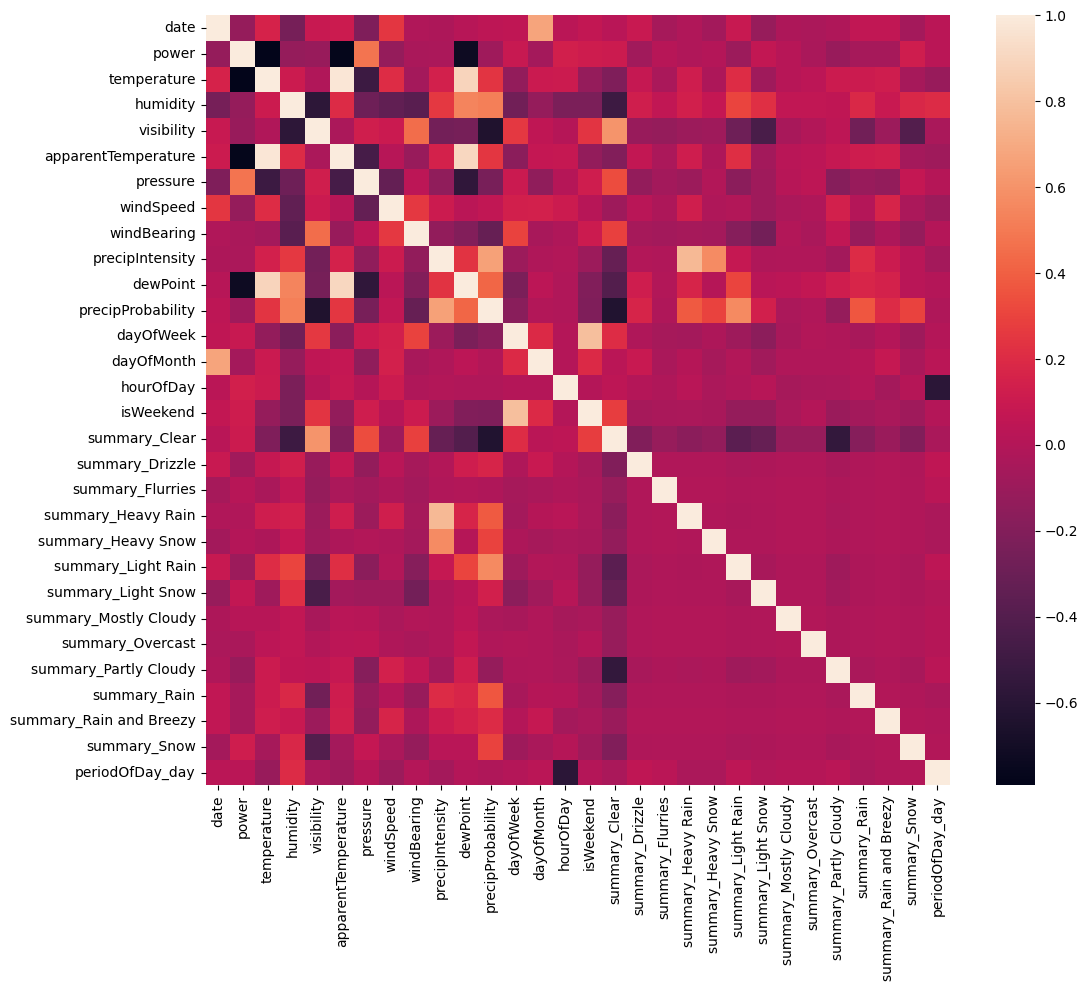

In [81]:
# Encode the categorical columns of the df
powerWeathEncDf = pd.get_dummies(powerWeathDf)
powerWeathEncDf = powerWeathEncDf.drop(columns=["periodOfDay_night"])

# Plot correlation matrix heatmap
plt.subplots(figsize=(12,10))
sns.heatmap(powerWeathEncDf.corr())

In [ ]:
# TODO Perform Recursive Feature Elimination with Random Forest as backend model 